# Jupyter Notebook to Visualize TopoFlow Output

TopoFlow stores values of output variables in multiple file formats, but the main one is netCDF format.  This Jupyter notebook shows how to read values of variables from TopoFlow netCDF output files and to then visualize them.

The TopoFlow model consists of a collection of <b>components</b>, each of which is able to model a particular hydrologic process in a particular way.  It provides a very flexible, <b>plug-and-play</b> modeling environment where a user specifies which set of components they want to use.  The EMELI framework then assembles these components into a functioning hydrologic model.

Each TopoFlow component has its own configuration file  or <b>cfg file</b> ending in the extension ".cfg".  These are text files that can be edited by hand or with scripts and they set the options, parameters, names of input files, etc. that are to be used by the component for a particular model run.  This particular model run is characterized by a <b>case prefix</b> (case as in scenario).  TopoFlow input files that describe static features of the site (a geographic bounding box) to be modeled start with a <b>site prefix</b> and do not change between model runs.  TopoFlow input and configuration files that correspond to a particular scenario (e.g. time period, climate forcing, parameter settings, choice of components, etc.) start with the case prefix.

In a model component's CFG file, there are toggles that determine which variables are to be written to files, and how often.  Since TopoFlow is a spatial hydrologic model, most variables are computed on a grid (2D array) that changes with each model time step.  Users can choose to write out this entire grid to a file at some time interval (save_grid_dt), and/or they can write out values for specific grid cells (0D) within the grid at some other time interval (save_pixels_dt).

The various types of TopoFlow output can be summarized as follows.  In each case, the output file contains of values of some variable (say V) that <b>vary in time</b>, that is, a <b>series</b>.  Output filenames start with the <b>case prefix</b>.  The dimensionality of the output is indicated in the output file name with "0D_", "1D_", "2D_" or "3D_" followed by a variable name abbreviation (e.g. "Q" or "d-flood").

<b>0D = Time series</b> <br>
Scalar values of V, at one or more model grid cells. <br>
Formats:  (1) netCDF, and (2) multi-column text (i.e. CSV) <br>
Utility:  topoflow/utils/ncts_files.py <br>
Example:  river depth over time for given grid cell <br>
Note:     monitored grid cells are specified in [case_prefix]_outlets.txt. <br>

<b>1D = Profile series</b> <br>
A 1D array of values of V, at one or more grid cells . <br>
Formats: (1) netCDF<br>
Utility:  topoflow/utils/ncps_files.py<br>
Example:  1D, vertical slice of a 3D array (e.g. soil moisture profile) <br>

<b>2D = Grid series (or stack)</b> <br>
A 2D array of values of V, for the entire model grid (all cells).<br>
Formats:  (1) netCDF, (2) RTS, (3) BOV <br>
Utility:  topoflow/utils/ncgs_files.py <br>
Example:  river discharges for the entire model grid <br>

<b>3D = "Cube" series</b> <br>
A 3D array of values of V, for entire model grid and various depths.<br>
Formats:  (1) netCDF <br>
Utility:  topoflow/utils/nccs_files.py <br>
Example:  3D array of subsurface soil moisture (grid + depth). <br>


# Set up a conda environment with all dependencies

# Create some directories in your home directory

In [1]:
import glob
import os, os.path
import shutil

# site_prefix = 'Baro_Gam_1min'
case_prefix = 'Test1'

home_dir   = os.path.expanduser("~")
test_dir   = home_dir + '/TF_Output'
output_dir = test_dir + '/' + case_prefix
png_dir    = output_dir + '/' + 'png_files'

if not(os.path.exists( test_dir )):   os.mkdir( test_dir )
if not(os.path.exists( output_dir )): os.mkdir( output_dir)
if not(os.path.exists( png_dir )):    os.mkdir( png_dir)
    
os.chdir( output_dir )

# Import required Python packages

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import imageio

from topoflow.utils import ncgs_files
from topoflow.utils import ncts_files

Importing TopoFlow 3.6 packages:
   topoflow.utils
   topoflow.utils.tests
   topoflow.components
   topoflow.components.tests
   topoflow.framework
   topoflow.framework.tests
 
Paths for this package:
framework_dir = /Users/peckhams/Dropbox/TopoFlow_3.6/topoflow/framework/
parent_dir    = /Users/peckhams/Dropbox/TopoFlow_3.6/topoflow/
examples_dir  = /Users/peckhams/Dropbox/TopoFlow_3.6/topoflow/examples/
__file__      = /Users/peckhams/Dropbox/TopoFlow_3.6/topoflow/framework/emeli.py
__name__      = topoflow.framework.emeli
 


# Define some useful "stretch" functions

In [3]:
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.histogram.html

def histogram_equalize( grid, PLOT_NCS=False):
    (hist, bin_edges) = np.histogram( grid, bins=256)
    # hmin = hist.min()
    # hmax = hist.max()

    cs  = hist.cumsum()
    ncs = (cs - cs.min()) / (cs.max() - cs.min())
    ncs.astype('uint8');
    if (PLOT_NCS):
        plt.plot( ncs )

    flat = grid.flatten()
    flat2 = np.uint8( 255 * (flat - flat.min()) / (flat.max() - flat.min()) )
    grid2 = ncs[ flat2 ].reshape( grid.shape )
    return grid2

def power_stretch1( grid, p ):
    return grid**p

def power_stretch2( grid, a=1000, b=0.5):
    # Note: Try a=1000 and b=0.5
    gmin = grid.min()
    gmax = grid.max()
    norm = (grid - gmin) / (gmax - gmin)
    return (1 - (1 + a * norm)**(-b))

def power_stretch3( grid, a=1, b=2):
    # Note:  Try a=1, b=2 (shape of a quarter circle)
    gmin = grid.min()
    gmax = grid.max()
    norm = (grid - gmin) / (gmax - gmin)
    return (1 - (1 - norm**a)**b)**(1/b)

def log_stretch( grid, a=1 ):
    return np.log( (a * grid) + 1 )


# Read grid from a grid stack in a TF netCDF file

In [23]:
ncgs = ncgs_files.ncgs_file()

nc_file = 'Test1_2D-Q.nc'
# nc_file = 'Test1_2D-d-flood.nc'

ncgs.open_file( nc_file )
var_name_list = ncgs.get_var_names()
var_index = 3   # 0=time, 1=X, 2=Y, 3=V  ###############
var_name  = var_name_list[ var_index ]
long_name = ncgs.get_var_long_name( var_name )
var_units = ncgs.get_var_units( var_name )
n_grids   = ncgs.ncgs_unit.variables[ var_name ].n_grids

print('long_name =', long_name)
print('var_name  =', var_name)
print('var_units =', var_units)
print('n_grids   =', n_grids)
print('var_names in netCDF file =' )
print( var_name_list )

# Use these to set "extent" in plt.imshow().
minlon = ncgs.ncgs_unit.variables['X'].geospatial_lon_min
maxlon = ncgs.ncgs_unit.variables['X'].geospatial_lon_max
minlat = ncgs.ncgs_unit.variables['Y'].geospatial_lat_min
maxlat = ncgs.ncgs_unit.variables['Y'].geospatial_lat_max

# Read the second grid in the grid stack
time_index = 1
grid = ncgs.get_grid( var_name, time_index )

gmin = grid.min()
gmax = grid.max()
print( 'gmin =', gmin )
print( 'gmax =', gmax)

ncgs.close_file()

long_name = volumetric_discharge
var_name  = Q
var_units = m^3/s
n_grids   = 167
var_names in netCDF file =
['time', 'X', 'Y', 'Q']
gmin = 0.0
gmax = 3075.1648


# Apply a stretch to enchance image contrast

In [24]:
# grid2 = power_stretch1( grid, 0.5)
# grid2 = power_stretch1( grid, 0.2)
# grid2 = log_stretch( grid )
# grid2 = power_stretch2( grid )
grid2 = power_stretch3( grid, a=0.5 )
# grid2 = histogram_equalize( grid, PLOT_NCS=True)


# Create a color image of the grid

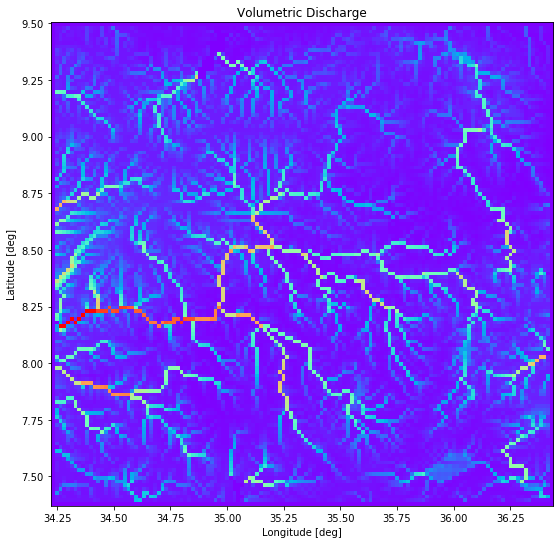

In [28]:
# figure = plt.figure(1, figsize=(9,9))
fig, ax = plt.subplots( figsize=(9,9))
im_title = long_name.replace('_', ' ').title()
ax.set_title( im_title )
ax.set_xlabel('Longitude [deg]')
ax.set_ylabel('Latitude [deg]')

# Choose a color map
cmap = 'rainbow'
# cmap = 'hsv'
# cmap = 'jet'
# cmap = 'gist_rainbow'  # reverse rainbow
# cmap = 'gist_ncar'
# cmap = 'gist_stern'

gmin = grid2.min()
gmax = grid2.max()
im = ax.imshow(grid2, interpolation='nearest', cmap=cmap,
               vmin=gmin, vmax=gmax,
               extent=[minlon, maxlon, minlat, maxlat])
        
# NOTE!  Saving must come before "showing" to avoid blank image.
im_file = 'Test_Image.jpg'   # format inferred from extension, or set format
plt.savefig( im_file )

plt.show()

# Create a set of image files from a TF grid stack

In [26]:
nc_file = 'Test1_2D-Q.nc'
# nc_file = 'Test1_2D-d-flood.nc'

ncgs.open_file( nc_file )
var_name_list = ncgs.get_var_names()
var_index = 3   # 0=time, 1=X, 2=Y, 3=V  ###############
var_name  = var_name_list[ var_index ]
long_name = ncgs.get_var_long_name( var_name )
print('var_name  =', var_name )
print('long_name =', long_name )

im_title = long_name.replace('_', ' ').title()
im_file_prefix = 'TF_Movie_Frame_'
time_pad_map = {1:'0000', 2:'000', 3:'00', 4:'0', 5:''}
cmap = 'rainbow'

print('Creating images from grid stack in nc_file:')
print('  ' + nc_file )
print('  ' + 'var name =', long_name)
print('This may take a few minutes.')
print('Working...')
time_index = 0

while (True):
    # print('time index =', time_index )
    try:
        grid = ncgs.get_grid( var_name, time_index )
    except:
        break
    time_index += 1
    ## grid2 = log_stretch( grid )
    ## grid2 = power_stretch1( grid )
    grid2 = power_stretch3( grid )
    ## grid2 = histogram_equalize( grid )
    gmin = grid2.min()
    gmax = grid2.max()

    fig, ax = plt.subplots( figsize=(6,6), dpi=192) 
    ax.set_title( im_title )
    ax.set_xlabel('Longitude [deg]')
    ax.set_ylabel('Latitude [deg]')
    im = ax.imshow(grid2, interpolation='nearest', cmap=cmap,
                   vmin=gmin, vmax=gmax,
                   extent=[minlon, maxlon, minlat, maxlat])
    
    # Build a filename for this image/frame
    tstr = str(time_index)
    pad = time_pad_map[ len(tstr) ]
    time_str = (pad + tstr)
    im_file = im_file_prefix + time_str + '.png' 
    im_file = (png_dir + '/' + im_file)

    plt.savefig( im_file )
    plt.close()

ncgs.close_file()
tstr = str(time_index)
print('Finished saving ' + tstr + ' images to PNG files.')

var_name  = Q
long_name = volumetric_discharge
Creating images from grid stack in nc_file:
  Test1_2D-Q.nc
  var name = volumetric_discharge
This may take a few minutes.
Working...
Finished saving 167 images to PNG files.


# Make a movie from a set of image files

In [27]:
fps = 10  # frames per second
mp4_file = 'Test_Movie.mp4'
im_file_list = sorted( glob.glob( png_dir + '/*.png' ) )
n_frames = len( im_file_list )

print('Creating movie from', n_frames, 'PNG files.')
## print('This may take a few minutes.')
print('Working...')
writer = imageio.get_writer( mp4_file, fps=fps )

for im_file in im_file_list:
    writer.append_data(imageio.imread( im_file ))
writer.close()
print('Finished creating movie, MP4 format.')
print('  ' + mp4_file)
print()


Creating movie from 167 PNG files.
Working...
Finished creating movie, MP4 format.
  Test_Movie.mp4



# Create a time series plot

var_names in netCDF file =
['time', 'df_79_4', 'df_76_14', 'df_79_29', 'df_59_48', 'df_60_48', 'df_76_45', 'df_74_44', 'df_81_56']



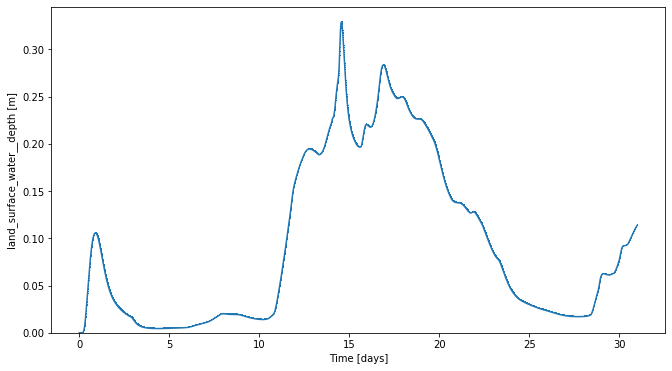

In [11]:
# nc_file = 'Test1_0D-Q.nc'
nc_file = 'Test1_0D-d-flood.nc'

ncts = ncts_files.ncts_file()
ncts.open_file( nc_file )
var_name_list  = ncts.get_var_names()
var_name = var_name_list[1]

print( 'var_names in netCDF file =' )
print( var_name_list )
print()

(series, times) = ncts.get_series( var_name )
long_name = series.long_name
v_units   = series.units
t_units   = times.units
values    = np.array( series )
times     = np.array( times )
# values = series[:]   # also works
# times  = times[:]    # also works

if (t_units == 'minutes'):
    # times = times / 60.0
    # t_units = 'hours'
    times = times / (60.0 * 24)
    t_units = 'days'

# ymin = values.min()
ymin = 0.0
ymax = values.max()

figure = plt.figure(1, figsize=(11,6))
# fig, ax = plt.subplots( figsize=(11,6))

# Set the plot point marker
# https://matplotlib.org/3.1.1/api/markers_api.html
marker = ','  # pixel
# marker = '.'  # point (small circle)
# marker = 'o'  # circle
# marker = '+'
# marker = 'x'

plt.plot( times, values, marker=marker)
plt.xlabel( 'Time' + ' [' + t_units + ']' )
plt.ylabel( long_name + ' [' + v_units + ']' )
plt.ylim( np.array(ymin, ymax) )

plt.show()

ncts.close_file()
